In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
from enum import Enum
import time
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### **RNN**

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):

        # input size -> Dimension of the input signal
        # outpusize -> Dimension of the output signal
        # hidden_dim -> Dimension of the rnn state
        # n_layers -> If >1, we are using a stacked RNN

        super().__init__()

        self.hidden_dim = hidden_dim

        self.input_size = input_size

        self.output_size = output_size

        # batch_first=True means that the first dimension of the input will be the batch_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

        # One linear layer to estimate mean
        self.linear1 = nn.Linear(hidden_dim, 4)

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h0=None):

        r_out, hidden = self.lstm(x, h0)
        r_out = r_out.reshape(-1, self.hidden_dim)
        sample = self.linear1(r_out)

        return hidden, sample

In [4]:
class RNN_extended(LSTM):

    def __init__(self, num_data_train, num_iter, sequence_length,
                 input_size, output_size, hidden_dim, n_layers, lr=0.001):

        super().__init__(input_size, output_size, hidden_dim, n_layers)

        self.hidden_dim = hidden_dim

        self.sequence_length = sequence_length

        self.num_layers = n_layers

        self.lr = lr #Learning Rate

        self.num_train = num_data_train #Number of training signals

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.num_iter = num_iter

        self.criterion = torch.nn.CrossEntropyLoss()

        # A list to store the loss evolution along training
        self.loss_during_training = []
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)


    def trainloop(self, x_train, y_train, x_val, y_val):

        # SGD Loop

        for e in range(int(self.num_iter)):

            self.optim.zero_grad()

            x = torch.Tensor(x_train).view([-1,1])
            y = torch.Tensor(y_train).view([-1]).to(torch.long)
            x, y = x.to(self.device), y.to(self.device)

            hid,sample = self.forward(x)

            loss = self.criterion(sample,y)

            loss.backward()

            # This code helps to avoid vanishing exploiting gradients in RNNs
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(self.parameters(), 2.0)

            self.optim.step()

            self.loss_during_training.append(loss.item())

            with torch.no_grad():

                  running_loss = 0.

                  for i, x in enumerate(x_val):

                      x = torch.Tensor(x).view([-1,1])
                      y = torch.Tensor(y_val[i]).view([-1]).to(torch.long)
                      x, y = x.to(self.device), y.to(self.device)

                      hid,sample = self.forward(x)

                      loss = self.criterion(sample,y)

                      running_loss += loss.item()

                  self.valid_loss_during_training.append(running_loss/len(x_val))

            if(e % 50 == 0):
              print('\nTrain Epoch: {} -> Training Loss: {:.6f}'.format(e,self.loss_during_training[-1]))
              print('Train Epoch: {} -> Validation Loss: {:.6f}'.format(e,self.valid_loss_during_training[-1]))



    def eval_performance(self, x_test, y_test):
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for i,x in enumerate(x_test):
                x = torch.Tensor(x).view([-1,1])
                y = torch.Tensor(y_test[i]).view([-1]).to(torch.long)
                x, y = x.to(self.device), y.to(self.device)

                hid, sample= self.forward(x)
                equals = (torch.argmax(sample, dim=1) == y)
                accuracy += torch.mean(equals.type(torch.FloatTensor))

            return accuracy/len(x_test)

### **Lectura y procesado de experiencias**

In [5]:
with open("all_experiences.pickle", 'rb') as f:
    loaded_array = pickle.load(f)

Y = loaded_array[:,1:]
X = loaded_array[:,:-1]

X = [[int(sublist[1]) for sublist in row] for row in X]
Y = [[int(sublist[1]) for sublist in row] for row in Y]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, shuffle=True, random_state=42)

In [8]:
len(X_train)

44710

## **Entrenamiento**

In [9]:
T_train = len(X_train[0])

In [12]:
rnn_model = RNN_extended(num_data_train=len(X_train),num_iter=500,sequence_length=T_train,
                     input_size=1,output_size=1,hidden_dim=8,n_layers=1,lr=0.005)

In [13]:
rnn_model.trainloop(X_train,y_train, X_val, y_val)


Train Epoch: 0 -> Training Loss: 1.438930
Train Epoch: 0 -> Validation Loss: 1.401106

Train Epoch: 50 -> Training Loss: 0.957938
Train Epoch: 50 -> Validation Loss: 1.004042

Train Epoch: 100 -> Training Loss: 0.933723
Train Epoch: 100 -> Validation Loss: 0.974127

Train Epoch: 150 -> Training Loss: 0.917890
Train Epoch: 150 -> Validation Loss: 0.956835

Train Epoch: 200 -> Training Loss: 0.884881
Train Epoch: 200 -> Validation Loss: 0.938835

Train Epoch: 250 -> Training Loss: 0.841397
Train Epoch: 250 -> Validation Loss: 0.908989

Train Epoch: 300 -> Training Loss: 0.813370
Train Epoch: 300 -> Validation Loss: 0.893934

Train Epoch: 350 -> Training Loss: 0.797920
Train Epoch: 350 -> Validation Loss: 0.889157

Train Epoch: 400 -> Training Loss: 0.789484
Train Epoch: 400 -> Validation Loss: 0.888754

Train Epoch: 450 -> Training Loss: 0.784009
Train Epoch: 450 -> Validation Loss: 0.889658


In [14]:
print(rnn_model.eval_performance(X_test, y_test))

tensor(0.6481)


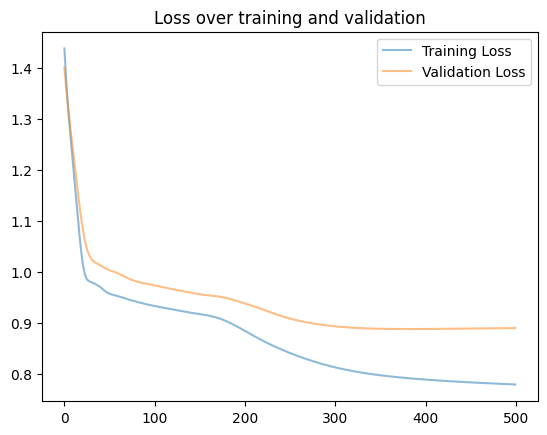

In [15]:
fig, ax = plt.subplots()
plt.plot(rnn_model.loss_during_training, label='Training Loss', alpha=0.5)
plt.plot(rnn_model.valid_loss_during_training, label='Validation Loss', alpha=0.5)
plt.title("Loss over training and validation")
plt.legend()

## **Guardado del modelo**

In [16]:
with open('lstm_model_actions.pkl', 'wb') as file:
    pickle.dump(rnn_model, file)